# Customer Segmentation Using RFM Analysis

This notebook performs RFM (Recency, Frequency, Monetary) analysis on the Online Retail dataset to segment customers based on their purchasing behavior and provide marketing recommendations for each segment.

## What is RFM Analysis?
- **Recency**: How recently did the customer make a purchase?
- **Frequency**: How often do they make purchases?
- **Monetary**: How much money have they spent?

Using these three metrics, we can identify different customer segments and tailor marketing strategies accordingly.

## Step 1: Import Required Libraries
Loading essential libraries for data analysis, manipulation, and visualization.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Load the Online Retail Dataset
Loading the Online Retail dataset and examining the first few rows to understand the data structure.

In [5]:
df = pd.read_excel('Online_Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Step 3: Explore Dataset Information
Getting basic information about the dataset structure, data types, and memory usage.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Step 4: Check for Missing Values
Identifying missing values in each column to understand what data cleaning is needed.

In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## Step 5: Data Cleaning and Preparation
Cleaning the data for RFM analysis by:
- Removing rows without CustomerID (can't analyze customers without IDs)
- Converting InvoiceDate to datetime format
- Creating TotalPrice column (Quantity × UnitPrice)

In [8]:
df.dropna(subset=['CustomerID'], inplace=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

## Step 6: Verify Cleaned Data
Checking the cleaned dataset and confirming our data preparation was successful.

In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [10]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64

## Step 7: Calculate RFM Metrics
Creating RFM metrics for each customer:
- **Recency**: Days since last purchase (from analysis date)
- **Frequency**: Number of unique invoices (purchases)
- **Monetary**: Total amount spent

In [11]:
analysis_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

Rec_freq_monetary = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
Rec_freq_monetary.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
Rec_freq_monetary.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


## Step 8: Create RFM Scores
Converting RFM metrics into scores (1-5 scale):
- **R_score**: Lower recency = higher score (recent customers get higher scores)
- **F_score**: Higher frequency = higher score
- **M_score**: Higher monetary = higher score

In [12]:
Rec_freq_monetary['R_score'] = pd.qcut(Rec_freq_monetary['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
Rec_freq_monetary['F_score'] = pd.qcut(Rec_freq_monetary['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
Rec_freq_monetary['M_score'] = pd.qcut(Rec_freq_monetary['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

Rec_freq_monetary['Recency_Frequency_Score'] = Rec_freq_monetary['R_score'] + Rec_freq_monetary['F_score'] + Rec_freq_monetary['M_score']
Rec_freq_monetary.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,Recency_Frequency_Score
0,12346.0,326,2,0.00,1,2,1,4
1,12347.0,2,7,4310.00,5,4,5,14
2,12348.0,75,4,1797.24,2,3,4,9
3,12349.0,19,1,1757.55,4,1,4,9
4,12350.0,310,1,334.40,1,1,2,4


## Step 9: Customer Segmentation
Creating customer segments based on combined RFM scores:
- **Champions** (13-15): Best customers - high value, frequent, recent
- **Loyal Customers** (10-12): Good customers - regular buyers
- **Potential Loyalists** (7-9): Customers with potential
- **At Risk** (4-6): Customers who might leave
- **Lost** (3 or less): Inactive customers

In [13]:
def segment_customer(score):
    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal Customers'
    elif score >= 7:
        return 'Potential Loyalist'
    elif score >= 4:
        return 'At Risk'
    else:
        return 'Lost'
    
Rec_freq_monetary['Customer_Segment'] = Rec_freq_monetary['Recency_Frequency_Score'].apply(segment_customer)
Rec_freq_monetary.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,Recency_Frequency_Score,Customer_Segment
0,12346.0,326,2,0.00,1,2,1,4,At Risk
1,12347.0,2,7,4310.00,5,4,5,14,Champions
2,12348.0,75,4,1797.24,2,3,4,9,Potential Loyalist
3,12349.0,19,1,1757.55,4,1,4,9,Potential Loyalist
4,12350.0,310,1,334.40,1,1,2,4,At Risk


## Step 10: Visualize Customer Segments
Creating a bar chart to show the distribution of customers across different segments.

C:\Users\Admin\AppData\Local\Temp\ipykernel_12552\725820682.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='Blues_d')


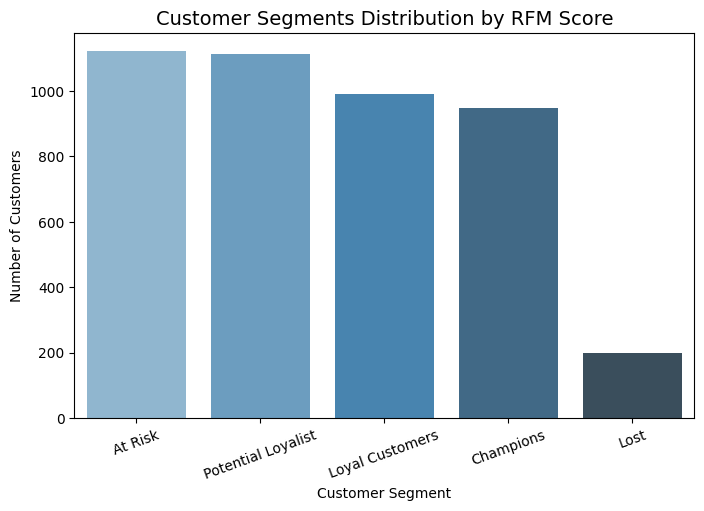

In [14]:
segment_counts = Rec_freq_monetary['Customer_Segment'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='Blues_d')
plt.title('Customer Segments Distribution by RFM Score', fontsize=14)
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=20)
plt.show()

## Step 11: RFM Distribution Analysis
Visualizing the distribution of Recency, Frequency, and Monetary values to understand customer behavior patterns.

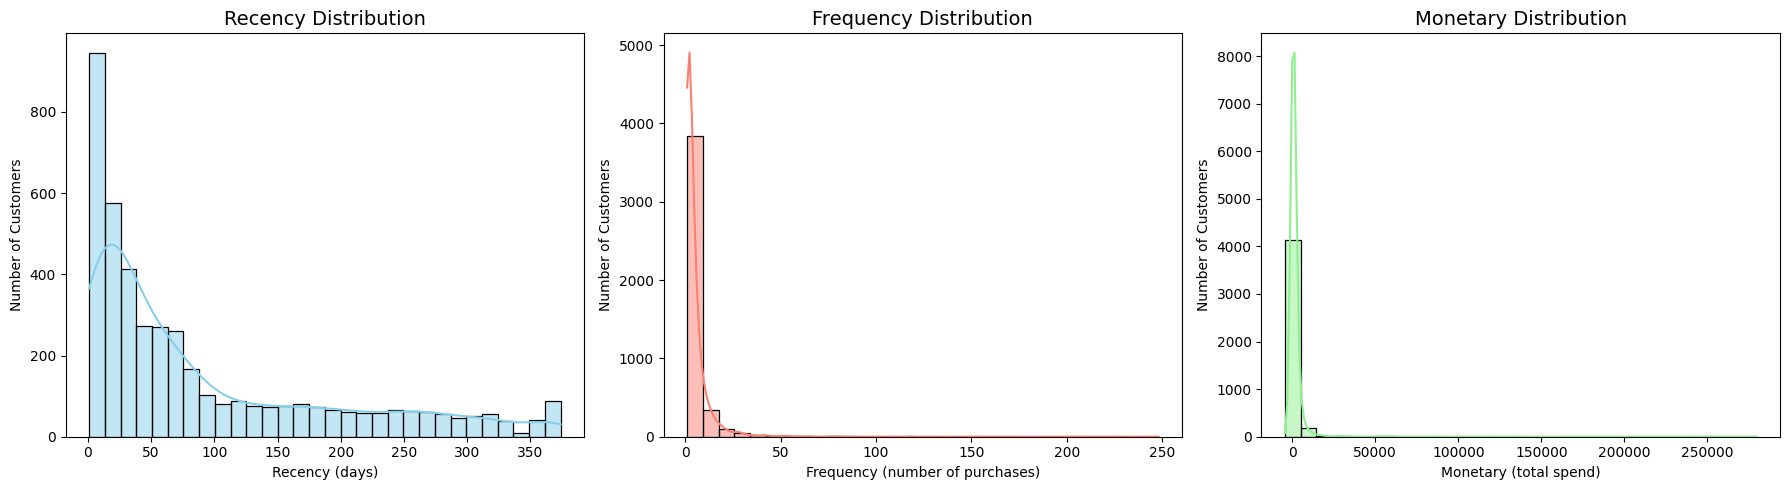

In [15]:
# RFM Distribution Visualization
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.histplot(Rec_freq_monetary['Recency'], bins=30, kde=True, color='skyblue')
plt.title('Recency Distribution', fontsize=14)
plt.xlabel('Recency (days)')
plt.ylabel('Number of Customers')
plt.subplot(1,3,2)
sns.histplot(Rec_freq_monetary['Frequency'], bins=30, kde=True, color='salmon')
plt.title('Frequency Distribution', fontsize=14)
plt.xlabel('Frequency (number of purchases)')
plt.ylabel('Number of Customers')
plt.subplot(1,3,3)
sns.histplot(Rec_freq_monetary['Monetary'], bins=30, kde=True, color='lightgreen')
plt.title('Monetary Distribution', fontsize=14)
plt.xlabel('Monetary (total spend)')
plt.ylabel('Number of Customers')
plt.tight_layout()
plt.show()

## Step 12: RFM Heatmap
Creating a heatmap showing the relationship between Recency and Frequency scores, with Monetary value as the color intensity.

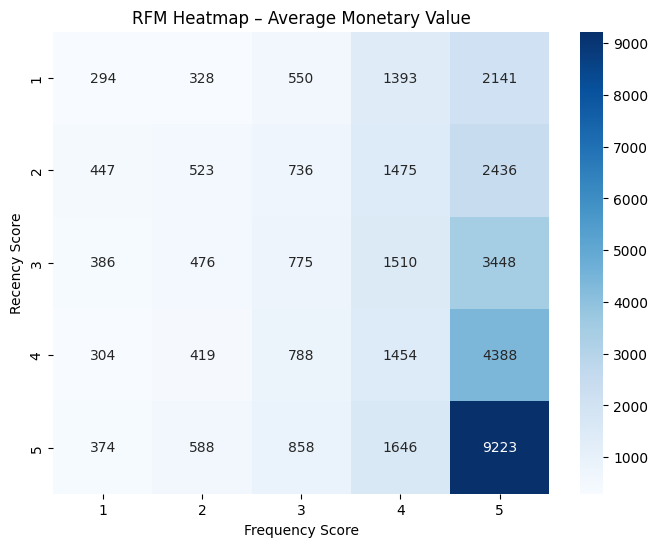

In [16]:
rfm_heatmap = Rec_freq_monetary.pivot_table(
    index='R_score', 
    columns='F_score', 
    values='Monetary', 
    aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(rfm_heatmap, cmap='Blues', annot=True, fmt=".0f")
plt.title('RFM Heatmap – Average Monetary Value')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()

## Step 13: Segment Comparison
Comparing average RFM values across different customer segments to understand their characteristics.

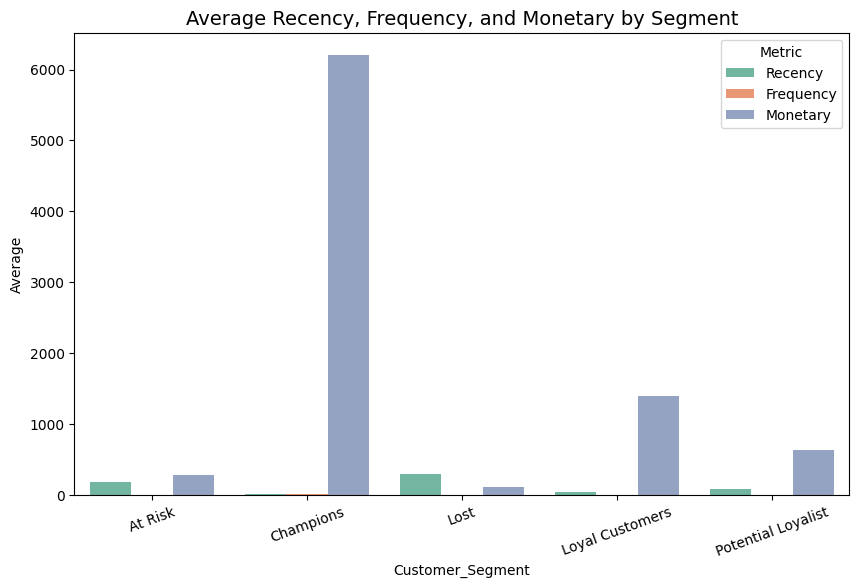

In [17]:
segment_avg = Rec_freq_monetary.groupby('Customer_Segment')[['Recency','Frequency','Monetary']].mean().reset_index()

segment_avg_melted = segment_avg.melt(id_vars='Customer_Segment', var_name='Metric', value_name='Average')
plt.figure(figsize=(10,6))
sns.barplot(data=segment_avg_melted, x='Customer_Segment', y='Average', hue='Metric', palette='Set2')
plt.title('Average Recency, Frequency, and Monetary by Segment', fontsize=14)
plt.xticks(rotation=20)
plt.show()


## Step 14: Customer Segment Analysis & Insights

Let's analyze each segment and understand their characteristics:

In [18]:
# Display segment statistics
segment_summary = Rec_freq_monetary.groupby('Customer_Segment').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
    'Frequency': 'mean', 
    'Monetary': 'mean'
}).round(2)

segment_summary.columns = ['Customer Count', 'Avg Recency (days)', 'Avg Frequency', 'Avg Monetary (£)']
print("Customer Segment Summary:")
print("=" * 50)
segment_summary

Customer Segment Summary:


,Customer Count,Avg Recency (days),Avg Frequency,Avg Monetary (£)
Customer_Segment,,,,
At Risk,1121,176.95,1.30,279.20
Champions,949,13.49,14.10,6206.01
Lost,198,290.10,1.00,111.18
Loyal Customers,990,43.13,4.61,1390.12
Potential Loyalist,1114,81.81,2.32,627.78


## Step 15: Marketing Recommendations for Each Segment

Based on our RFM analysis, here are targeted marketing strategies for each customer segment:

In [19]:
# Marketing Recommendations
marketing_recommendations = {
    'Champions': [
        'Reward them with VIP treatment and exclusive offers',
        'Ask for reviews and referrals',
        'Early access to new products',
        'Personalized thank you messages',
        'Loyalty program with premium benefits'
    ],
    'Loyal Customers': [
        'Upsell higher value products',
        'Cross-sell complementary items',
        'Loyalty rewards and points program', 
        'Birthday and anniversary offers',
        'Product recommendations based on purchase history'
    ],
    'Potential Loyalist': [
        'Membership programs to increase engagement',
        'Free shipping offers to encourage more purchases',
        'Product education and tutorials',
        'Social media engagement campaigns',
        'Seasonal promotions to boost frequency'
    ],
    'At Risk': [
        'Re-engagement campaigns with special discounts',
        'Survey to understand why they stopped buying',
        'Limited-time comeback offers',
        'Personalized email campaigns',
        'Win-back promotions (20-30% discounts)'
    ],
    'Lost': [
        'Deep discount offers (40-50% off)',
        'Product updates and new arrivals notifications',
        'Apology campaigns with significant incentives',
        'Reactivation campaigns with free shipping',
        'Survey about their experience and needs'
    ]
}

# Display recommendations
for segment, recommendations in marketing_recommendations.items():
    print(f"\n🎯 {segment.upper()} SEGMENT:")
    print("=" * 40)
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    print()


🎯 CHAMPIONS SEGMENT:
1. Reward them with VIP treatment and exclusive offers
2. Ask for reviews and referrals
3. Early access to new products
4. Personalized thank you messages
5. Loyalty program with premium benefits


🎯 LOYAL CUSTOMERS SEGMENT:
1. Upsell higher value products
2. Cross-sell complementary items
3. Loyalty rewards and points program
4. Birthday and anniversary offers
5. Product recommendations based on purchase history


🎯 POTENTIAL LOYALIST SEGMENT:
1. Membership programs to increase engagement
2. Free shipping offers to encourage more purchases
3. Product education and tutorials
4. Social media engagement campaigns
5. Seasonal promotions to boost frequency


🎯 AT RISK SEGMENT:
1. Re-engagement campaigns with special discounts
2. Survey to understand why they stopped buying
3. Limited-time comeback offers
4. Personalized email campaigns
5. Win-back promotions (20-30% discounts)


🎯 LOST SEGMENT:
1. Deep discount offers (40-50% off)
2. Product updates and new arrivals n

## Step 16: Customer Value Analysis
Let's calculate the customer lifetime value and revenue contribution by segment:

In [20]:
# Calculate revenue contribution by segment
segment_revenue = Rec_freq_monetary.groupby('Customer_Segment').agg({
    'CustomerID': 'count',
    'Monetary': ['sum', 'mean']
}).round(2)

segment_revenue.columns = ['Customer_Count', 'Total_Revenue', 'Avg_Revenue_Per_Customer']
segment_revenue['Revenue_Percentage'] = (segment_revenue['Total_Revenue'] / segment_revenue['Total_Revenue'].sum() * 100).round(2)

print("Revenue Analysis by Customer Segment:")
print("=" * 50)
segment_revenue

Revenue Analysis by Customer Segment:


,Customer_Count,Total_Revenue,Avg_Revenue_Per_Customer,Revenue_Percentage
Customer_Segment,,,,
At Risk,1121,312987.46,279.20,3.77
Champions,949,5889501.35,6206.01,70.96
Lost,198,22014.18,111.18,0.27
Loyal Customers,990,1376221.27,1390.12,16.58
Potential Loyalist,1114,699341.55,627.78,8.43


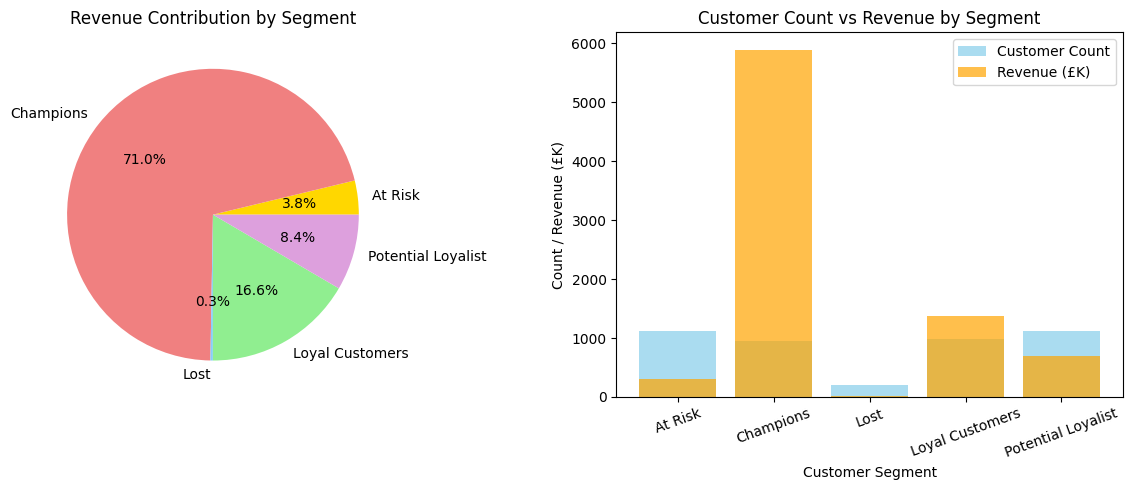

In [21]:
# Visualize revenue contribution
plt.figure(figsize=(12,5))

# Revenue pie chart
plt.subplot(1,2,1)
plt.pie(segment_revenue['Revenue_Percentage'], labels=segment_revenue.index, autopct='%1.1f%%', 
        colors=['gold', 'lightcoral', 'lightskyblue', 'lightgreen', 'plum'])
plt.title('Revenue Contribution by Segment')

# Customer count vs revenue
plt.subplot(1,2,2)
segments = segment_revenue.index
x_pos = range(len(segments))
plt.bar(x_pos, segment_revenue['Customer_Count'], alpha=0.7, color='skyblue', label='Customer Count')
plt.bar(x_pos, segment_revenue['Total_Revenue']/1000, alpha=0.7, color='orange', label='Revenue (£K)')
plt.xlabel('Customer Segment')
plt.ylabel('Count / Revenue (£K)')
plt.title('Customer Count vs Revenue by Segment')
plt.xticks(x_pos, segments, rotation=20)
plt.legend()

plt.tight_layout()
plt.show()

## Summary and Key Insights

### RFM Analysis Results:

#### **Customer Segments Identified:**
1. **Champions**: Top customers with high value, recent purchases, and frequent buying
2. **Loyal Customers**: Regular buyers who contribute steady revenue  
3. **Potential Loyalists**: Customers with growth potential
4. **At Risk**: Customers showing signs of declining engagement
5. **Lost**: Inactive customers who need re-engagement

#### **Key Business Insights:**
- **Revenue Concentration**: Champions and Loyal customers likely drive majority of revenue
- **Retention Priority**: Focus on preventing "At Risk" customers from becoming "Lost"
- **Growth Opportunity**: Convert "Potential Loyalists" into higher value segments
- **Win-back Campaigns**: Re-engage "Lost" customers with compelling offers

#### **Marketing Action Plan:**
- **Immediate**: Launch win-back campaigns for Lost customers
- **Short-term**: Implement loyalty programs for Potential Loyalists  
- **Long-term**: Develop VIP programs for Champions and Loyal customers
- **Ongoing**: Monitor segment movement and adjust strategies accordingly

#### **RFM Analysis Benefits:**
- **Data-driven decisions**: Segment customers based on actual behavior
- **Personalized marketing**: Tailor messages and offers to each segment
- **Resource optimization**: Focus marketing spend on high-value segments
- **Customer retention**: Identify at-risk customers before they churn
- **Revenue growth**: Maximize customer lifetime value through targeted campaigns

This RFM analysis provides a solid foundation for customer-centric marketing strategies that can improve retention, increase revenue, and optimize marketing ROI.